# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
# imports
import pandas as pd
from datetime import date, timedelta, datetime

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
# load weekly sales dataset

def load_data():
    filename = "../Datasets/online_retail_dataset.csv"

    data = pd.read_csv(filename,
        usecols=["week", "United Kingdom"],
        parse_dates=["week"],
        index_col=["week"])

    data.columns = ['sales']
    
    return data

data = load_data()
data.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<AxesSubplot:xlabel='week'>

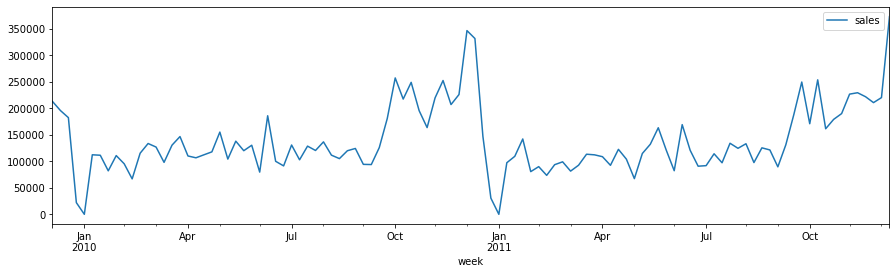

In [3]:
data.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [4]:
# Create the feature month from the timestamp.

dtf = DatetimeFeatures(variables="index", features_to_extract=["month"])
# Extract the datetime features
data = dtf.fit_transform(data)
# Show new variables
data.head()

,sales,month
week,,
2009-12-06,213000.35,12
2009-12-13,195810.04,12
2009-12-20,182396.74,12
2009-12-27,22007.77,12
2010-01-03,0.00,1


In [5]:
# Create the feature lag-1 by lagging 1 week of data.

lagf = LagFeatures(
    variables=["sales"],  # the input variables
    freq=["7D"],  # move 1 week forward
    missing_values="ignore",
)

# Add the lag features.
data = lagf.fit_transform(data)

# Show new variables
data[[v for v in data.columns if "lag" in v]].head()

,sales_lag_7D
week,
2009-12-06,NaN
2009-12-13,213000.35
2009-12-20,195810.04
2009-12-27,182396.74
2010-01-03,22007.77


In [6]:
# https://feature-engine.trainindata.com/en/latest/api_doc/timeseries/forecasting/WindowFeatures.html

winf = WindowFeatures(
    variables=["sales"],  # the input variables
    window=["14D", "28D"],  # average of 2, 4, previous weeks
    freq="7D",  # move 1 week forward
    missing_values="ignore",
#     functions=['mean', 'min', 'max']
)

# Add the window features.
data = winf.fit_transform(data)

# Show new variables
data[[v for v in data.columns if "window" in v]].head()

,sales_window_14D_mean,sales_window_28D_mean
week,,
2009-12-06,NaN,NaN
2009-12-13,213000.350,213000.350000
2009-12-20,204405.195,204405.195000
2009-12-27,189103.390,197069.043333
2010-01-03,102202.255,153303.725000


In [7]:
# Transform the month with the sine and cosine functions
# https://feature-engine.readthedocs.io/en/latest/api_doc/creation/CyclicalFeatures.html

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month"],
    # Whether to drop the original features.
    drop_original=False,
)

data = cyclicf.fit_transform(data)

data[[v for v in data.columns if "month" in v]].head()

,month,month_sin,month_cos
week,,,
2009-12-06,12,-2.449294e-16,1.000000
2009-12-13,12,-2.449294e-16,1.000000
2009-12-20,12,-2.449294e-16,1.000000
2009-12-27,12,-2.449294e-16,1.000000
2010-01-03,1,5.000000e-01,0.866025


In [8]:
# Drop missing data.
data.isnull().sum()

sales                    0
month                    0
sales_lag_7D             1
sales_window_14D_mean    1
sales_window_28D_mean    1
month_sin                0
month_cos                0
dtype: int64

In [9]:
print(data.shape)

imputer = DropMissingData()

data = imputer.fit_transform(data)

print(data.shape)
data.isnull().sum()

(106, 7)
(105, 7)


sales                    0
month                    0
sales_lag_7D             0
sales_window_14D_mean    0
sales_window_28D_mean    0
month_sin                0
month_cos                0
dtype: int64

In [10]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["sales"])

data = drop_ts.fit_transform(data)

data.head()

,month,sales_lag_7D,sales_window_14D_mean,sales_window_28D_mean,month_sin,month_cos
week,,,,,,
2009-12-13,12,213000.35,213000.350,213000.350000,-2.449294e-16,1.000000
2009-12-20,12,195810.04,204405.195,204405.195000,-2.449294e-16,1.000000
2009-12-27,12,182396.74,189103.390,197069.043333,-2.449294e-16,1.000000
2010-01-03,1,22007.77,102202.255,153303.725000,5.000000e-01,0.866025
2010-01-10,1,0.00,11003.885,100053.637500,5.000000e-01,0.866025


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [11]:
data1 = load_data()
data1.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [12]:
data1.index.min(), data1.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [13]:
timenow = datetime(2011,12,11,0,0,0)
last_time = timenow - timedelta(days=30) #go one month prior to get 1 week ahead
last_time

datetime.datetime(2011, 11, 11, 0, 0)

In [14]:
X_train = data1[data1.index <= last_time]
X_test = data1[data1.index > last_time]

X_train.shape, X_test.shape

((101, 1), (5, 1))

In [15]:
X_train.index.min(), X_train.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-11-06 00:00:00'))

In [16]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

In [17]:
# We line up the engineering steps within
# a pipeline.

pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
#         ("drop_ts", drop_ts),
    ]
)

In [18]:
data = pipe.fit_transform(data1)
data.head()

,sales,month,sales_lag_7D,sales_window_14D_mean,sales_window_28D_mean,month_sin,month_cos
week,,,,,,,
2009-12-13,195810.04,12,213000.35,213000.350,213000.350000,-2.449294e-16,1.000000
2009-12-20,182396.74,12,195810.04,204405.195,204405.195000,-2.449294e-16,1.000000
2009-12-27,22007.77,12,182396.74,189103.390,197069.043333,-2.449294e-16,1.000000
2010-01-03,0.00,1,22007.77,102202.255,153303.725000,5.000000e-01,0.866025
2010-01-10,112318.85,1,0.00,11003.885,100053.637500,5.000000e-01,0.866025


In [19]:
# The offset for the test set

In [20]:
# Split the data in time.
X_train = data[data.index <= last_time]
X_test = data[data.index > last_time]

X_train.shape, X_test.shape

((100, 7), (5, 7))

In [21]:
# Target (in this dataset, is is the train set itself)
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Machine Learning

In [22]:
mse = mean_squared_error

In [23]:
print("train rmse: ", mse(y_train, X_train["sales_lag_7D"], squared=False))
print("test rmse: ",  mse(y_test,  X_test["sales_lag_7D"],  squared=False))

train rmse:  49070.886831060256
test rmse:  68707.90119343685


In [24]:
def fit_model(m, xn, yn, xt, yt):
    m.fit(xn, yn)
    y_train_preds = m.predict(xn)
    y_test_preds  = m.predict(xt)
    print(m, "train rmse: ", mse(yn, y_train_preds, squared=False))
    print(m, "test rmse: ",  mse(yt, y_test_preds,  squared=False))
    
    return None

In [27]:
# Model(s)
LR = Lasso(alpha = 100, random_state=0)
fit_model(LR, X_train, y_train, X_test, y_test)

Lasso(alpha=100, random_state=0) train rmse:  41589.31511914102
Lasso(alpha=100, random_state=0) test rmse:  74711.15525726195
